In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

np.set_printoptions(precision=3)

# Text Feature Extraction and Clustering

Term frequency - inverse document frequency (tf-idf) is a method to evaluate how important is a word in a document. It is a model to transform textual representation of information into a vector-space model (VSM)

VSM is a model representing textual information as a vector which:
1.  could represent the importance of a term (tf–idf) or even the absence or;
2. represent presence (Bag of Words) of a term in a document.

## Term Frequency - Inverse Document Frequency (tf-idf)

The **term frequency** of a document $d$ with respect a term $t$ is defined as:
$$
    \text{tf}(t, d) = \sum_{\hat t \in d}\mathbb{1}_{\hat t = t}
$$


In [64]:
count_vec = CountVectorizer()
# Dense representation: |D| x F
train_docs = ["this is a test", "this is another test", "that is the final test", "what is this about?"]
train_docs = ["esta es una prueba", "esta es otra prueba", "esa fue la prueba final", "¿De qué es esto?"]
Mtf = count_vec.fit_transform(train_docs)
Mtf.todense()

matrix([[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [48]:
count_vec.vocabulary_

{'esta': 3,
 'es': 1,
 'una': 11,
 'prueba': 9,
 'otra': 8,
 'esa': 2,
 'fue': 6,
 'la': 7,
 'final': 5,
 'de': 0,
 'qué': 10,
 'esto': 4}

The main problem with a a term frequency model is that is scales up frequent terms and scales down rare terms, which may be more informative than higher frequency terms. **Term frequency - inverse document frequency**, or tf-id, attempts to solve that by logarithmically scaling up rare terms and scaling down higher order terms.

We define the inverse document frequency (**idf**) as:
$$
    \text{idf}(t) = \log \frac{|D|}{1 + |\{d:  t \in \ d\}|}
$$

Where $|D|$ is the number of documents in the corpus and, $|\{d:  t \in \ d\}|$ is the number of documents containing the term $t$

Finally, the tf-idf formula is defined as:

$$
    \text{tf-idf}(t) = \text{df}(t, d) \times \text{idf}(t)
$$


In [49]:
card_D = len(train_docs)
idf = np.log((1 + card_D) / np.array([1 + np.sum([v in doc for doc in train_docs]) for v in count_vec.vocabulary_])) + 1

for term, weight in zip(count_vec.vocabulary_, idf):
    print(f"{term}\t{weight:0.2f}")

esta	1.51
es	1.00
una	1.92
prueba	1.22
otra	1.92
esa	1.92
fue	1.92
la	1.92
final	1.92
de	1.92
qué	1.92
esto	1.92


The matrix $\text{tf-idf}$ is defined as
$$
    M_{\text{tf-idf}} = M_{tf} \times M_{idf}
$$

In [50]:
Mtf_idf = Mtf @ np.identity(idf.shape[0]) *  idf
# L2 normalizatoin
Mtf_idf = Mtf_idf / norm(Mtf_idf, ord=2, axis=1).reshape(-1, 1)
print(Mtf_idf)

[[0.    0.319 0.    0.39  0.    0.    0.    0.    0.    0.611 0.    0.611]
 [0.    0.319 0.    0.39  0.    0.    0.    0.    0.611 0.611 0.    0.   ]
 [0.    0.    0.447 0.    0.    0.447 0.447 0.447 0.    0.447 0.    0.   ]
 [0.463 0.307 0.    0.    0.588 0.    0.    0.    0.    0.    0.588 0.   ]]


We can combine the steps above using scikit-learn's `TfidfTransformer`

In [51]:
tfidf_trans = TfidfTransformer(norm="l2")
Mtf_idf = tfidf_trans.fit_transform(Mtf)
print(Mtf_idf.todense())

[[0.    0.409 0.    0.505 0.    0.    0.    0.    0.    0.409 0.    0.641]
 [0.    0.409 0.    0.505 0.    0.    0.    0.    0.641 0.409 0.    0.   ]
 [0.    0.    0.476 0.    0.    0.476 0.476 0.476 0.    0.304 0.    0.   ]
 [0.542 0.346 0.    0.    0.542 0.    0.    0.    0.    0.    0.542 0.   ]]


Lastly, we can make use of `CountVectorizer` and `TfidfTransformer` in one step using `TfidfVectorizer`

In [52]:
tfv = TfidfVectorizer(norm="l2", smooth_idf=True)
tfv_matrix = tfv.fit_transform(train_docs)
print(tfv_matrix.todense())

[[0.    0.409 0.    0.505 0.    0.    0.    0.    0.    0.409 0.    0.641]
 [0.    0.409 0.    0.505 0.    0.    0.    0.    0.641 0.409 0.    0.   ]
 [0.    0.    0.476 0.    0.    0.476 0.476 0.476 0.    0.304 0.    0.   ]
 [0.542 0.346 0.    0.    0.542 0.    0.    0.    0.    0.    0.542 0.   ]]


In order to measure the distance between two documents we make use of the cosine similarity

$$
    \cos \theta = \frac{a\cdot b}{||a||_2\cdot||b||_2}
$$

In [96]:
cosine_similarity(tfv_matrix)

array([[1.   , 0.59 , 0.124, 0.141],
       [0.59 , 1.   , 0.124, 0.141],
       [0.124, 0.124, 1.   , 0.   ],
       [0.141, 0.141, 0.   , 1.   ]])

In [97]:
# Since each row is already normalize, Mtfv @ Mtfv.T is equivalent to the
# dot product between any two documents
(tfv_matrix @ tfv_matrix.T).todense()

matrix([[1.   , 0.59 , 0.124, 0.141],
        [0.59 , 1.   , 0.124, 0.141],
        [0.124, 0.124, 1.   , 0.   ],
        [0.141, 0.141, 0.   , 1.   ]])

## Stemming and Lemmatization 

* *Stemming* usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.
* *Lemmatization* usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma

In [104]:
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

def spanish_stemmer(corpus, lang="spanish"):
    stemmer = SnowballStemmer(lang)
    corpus_tokens = word_tokenize(re.sub("[^\w\s]", "", corpus).lower(), language=lang)
    return [stemmer.stem(w) for w in corpus_tokens]

In [103]:
test_text = ("Los indicadores disponibles al segundo trimestre de 2018 sugieren que la "
             "economía mundial continuó expandiéndose a un ritmo relativamente elevado")
print(spanish_stemmer(test_text))

['los', 'indic', 'dispon', 'al', 'segund', 'trimestr', 'de', '2018', 'sugier', 'que', 'la', 'econom', 'mundial', 'continu', 'expand', 'a', 'un', 'ritm', 'relat', 'elev']


In [129]:
tf = TfidfVectorizer(tokenizer=spanish_stemmer)
m_tfidf = tf.fit_transform(train_docs)
print(m_tfidf.todense())

[[0.    0.409 0.    0.505 0.    0.    0.    0.    0.    0.409 0.    0.641]
 [0.    0.409 0.    0.505 0.    0.    0.    0.    0.641 0.409 0.    0.   ]
 [0.    0.    0.476 0.    0.    0.476 0.476 0.476 0.    0.304 0.    0.   ]
 [0.542 0.346 0.    0.    0.542 0.    0.    0.    0.    0.    0.542 0.   ]]


In [132]:
similarity_matrix = cosine_similarity(m_tfidf)
print(similarity_matrix)

[[1.    0.59  0.124 0.141]
 [0.59  1.    0.124 0.141]
 [0.124 0.124 1.    0.   ]
 [0.141 0.141 0.    1.   ]]


## Clustering

In [2]:
from numpy.random import randn, multivariate_normal
from scipy.cluster.hierarchy import cophenet, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

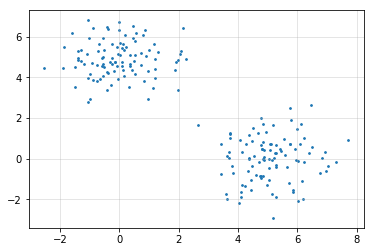

In [15]:
c1 = multivariate_normal([5, 0], [[1, 0], [0, 1]], size=100)
c2 = multivariate_normal([0, 5], [[1, 0], [0, 1]], size=100)
clust = np.r_[c1, c2]

plt.scatter(*clust.T, s=3)
plt.grid(alpha=0.4)

In [136]:
clustering = linkage(similarity_matrix, metric="cosine")
c, _  = cophenet(clustering, pdist(similarity_matrix))
print(c)

0.9949192988798035


Each row resulting from the `linkage` function will have the following form:
> `[idx1, idx2, distance, sample_count]`

In [139]:
clustering

array([[0.   , 1.   , 0.122, 2.   ],
       [3.   , 4.   , 0.695, 3.   ],
       [2.   , 5.   , 0.73 , 4.   ]])

References:

1. http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/
2. https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/
3. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
4. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/